# Will the client subscribe

## Description

This notebook aims to predict the success rate at which clients subscribe to bank plans. In a more broad point of view, it predicts the success of bank telemarketing.

## Data

The data used is gathered from this [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). 

This dataset is publicly available for research. The details are described in S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001.

Available at: [pdf](http://dx.doi.org/10.1016/j.dss.2014.03.001) and [bib](http://www3.dsi.uminho.pt/pcortez/bib/2014-dss.txt)



# Importing

In [64]:
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from google.colab import files
from sklearn.preprocessing import OrdinalEncoder

import io

In [65]:
# Two files are targetted: bank-additional-full.csv and bank-additional.csv
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full (1).csv
Saving bank-additional.csv to bank-additional (1).csv


In [66]:
import csv

# Read CSV data using pandas 
# The data is read in a DataFrame 

# Train data
train_data = pd.read_table(io.BytesIO(uploaded['bank-additional-full.csv']), sep=";", quotechar='"', quoting=csv.QUOTE_ALL)
# Test data
test_data = pd.read_table(io.BytesIO(uploaded['bank-additional.csv']), sep=";", quotechar='"', quoting=csv.QUOTE_ALL)

def convertDataToPlottable(dataset):
  # Convert the boolean y (yes | no) result into [-1 1] range, so it can be plotted
  dataset['subscribed'] = np.where(dataset.y == 'yes', 1, 0)
  dataset['previous'] = dataset.default.map(dict(yes=1, no=-1, unknown=0))

convertDataToPlottable(train_data)
convertDataToPlottable(test_data)

The data is composed of **41188** objects of **21** attributes, one of which is the boolean of interest (`yes` | `no`).

In [67]:
pd.set_option('display.max_columns', None)
train_data.head(10)

age          job  marital            education  default housing loan  \
0   56    housemaid  married             basic.4y       no      no   no   
1   57     services  married          high.school  unknown      no   no   
2   37     services  married          high.school       no     yes   no   
3   40       admin.  married             basic.6y       no      no   no   
4   56     services  married          high.school       no      no  yes   
5   45     services  married             basic.9y  unknown      no   no   
6   59       admin.  married  professional.course       no      no   no   
7   41  blue-collar  married              unknown  unknown      no   no   
8   24   technician   single  professional.course       no     yes   no   
9   25     services   single          high.school       no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0  telephone   may         mon       261         1    999        -1   
1  telephone   may         mon       149         1    999         0   
2  telephone   may         mon       226         1    999        -1   
3  telephone   may         mon       151         1    999        -1   
4  telephone   may         mon       307         1    999        -1   
5  telephone   may         mon       198         1    999         0   
6  telephone   may         mon       139         1    999        -1   
7  telephone   may         mon       217         1    999         0   
8  telephone   may         mon       380         1    999        -1   
9  telephone   may         mon        50         1    999        -1   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent           1.1          93.994          -36.4      4.857   
1  nonexistent           1.1          93.994          -36.4      4.857   
2  nonexistent           1.1          93.994          -36.4      4.857   
3  nonexistent           1.1          93.994          -36.4      4.857   
4  nonexistent           1.1          93.994          -36.4      4.857   
5  nonexistent           1.1          93.994          -36.4      4.857   
6  nonexistent           1.1          93.994          -36.4      4.857   
7  nonexistent           1.1          93.994          -36.4      4.857   
8  nonexistent           1.1          93.994          -36.4      4.857   
9  nonexistent           1.1          93.994          -36.4      4.857   

   nr.employed   y  subscribed  
0       5191.0  no           0  
1       5191.0  no           0  
2       5191.0  no           0  
3       5191.0  no           0  
4       5191.0  no           0  
5       5191.0  no           0  
6       5191.0  no           0  
7       5191.0  no           0  
8       5191.0  no           0  
9       5191.0  no           0

In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# Visualising and Analizing

This step is crucial and it determines the success of the model training.

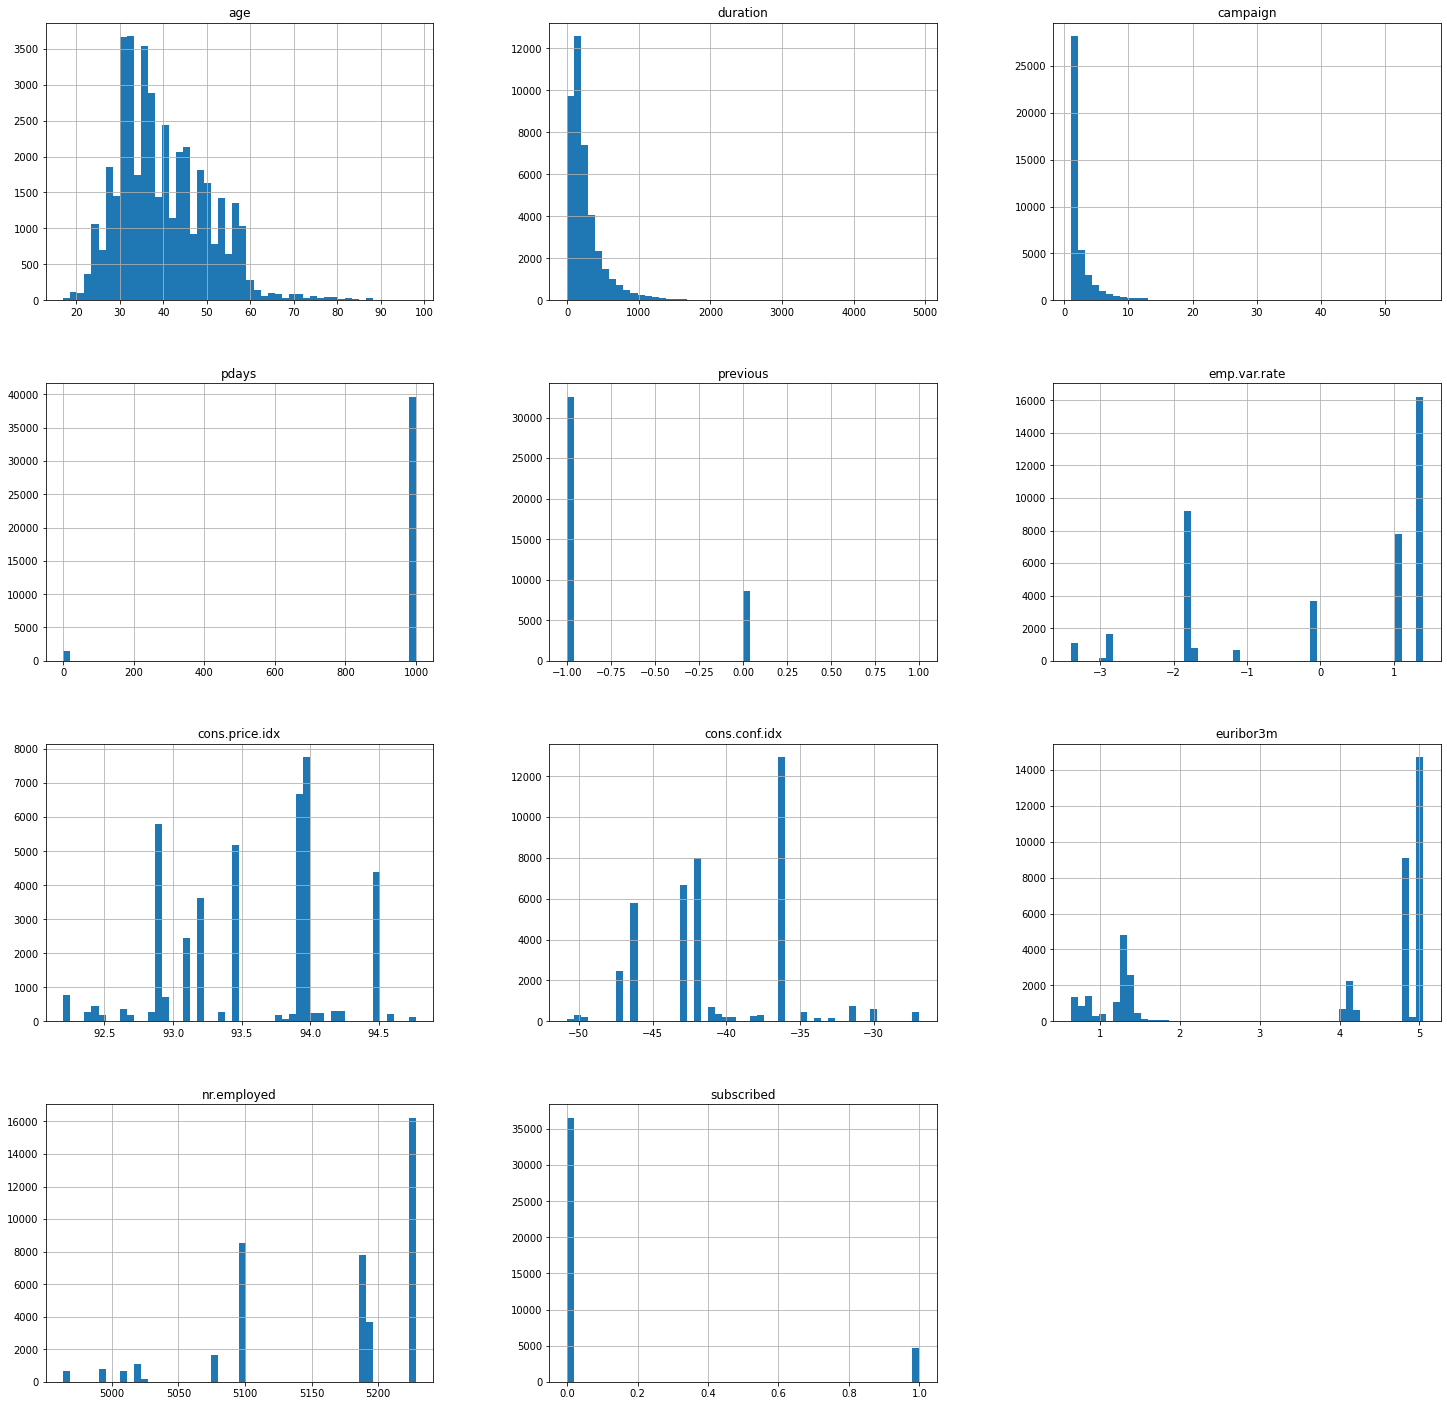

In [69]:
train_data.hist(bins=50, figsize=(25,25))
plt.show()

## Histogram

By plotting histograms for each field, **inbalance** can be spotted.

The field `pdays` has almost all the values set to `999`, which means the client was never previously contacted. Since this field retains no meaningful data at the dataset level, it can be safely removed.

All the other fields appear to be looking fine either because they match the expected behavior, or because data is somewhat evenly distributed.

In [70]:
# Inspect value counts for pdays
train_data['pdays'].value_counts().head(10)

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
Name: pdays, dtype: int64

Next in line is a **scatter matrix**. This will help with elimination of hurtful relations between columns which decrease the realistic prediction model.

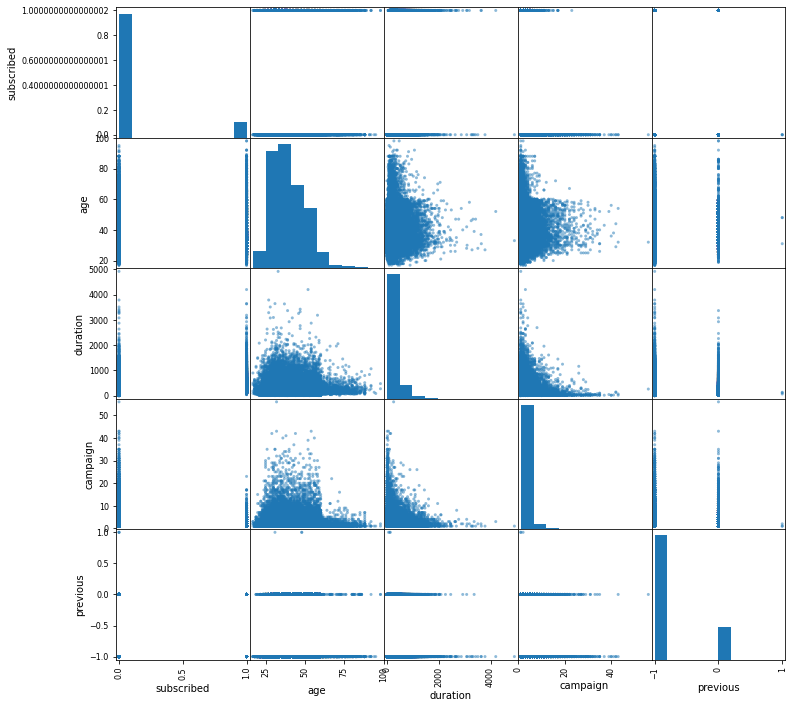

In [71]:
attr_to_scatter = ["subscribed", "age", "duration", "campaign", "previous"]
scatter_matrix(train_data[attr_to_scatter], figsize=(12, 12))
plt.show()

There are several entries which can be optionally removed.

1. Old people with long call time (duration)
2. People with large number of contacts and long call time (duration)

Removing these is not crucial, but it can be something to keep in mind.

There is, however, a tiny segment of the plots between `subscribed` and `duration` which unveils a possible flawd relation that the model might catch not up on.

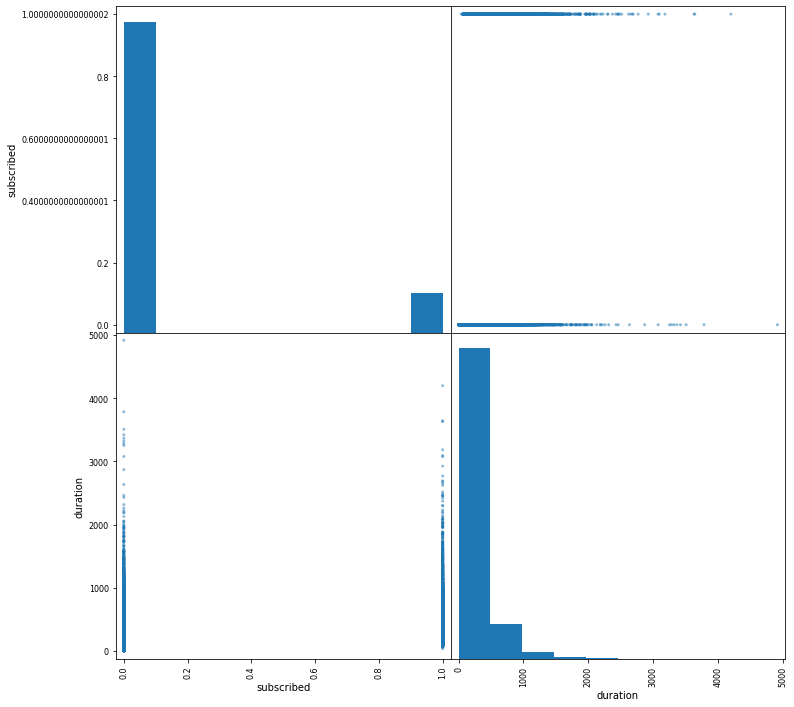

In [72]:
scatter_matrix(train_data[["subscribed", "duration"]], figsize=(12, 12))
plt.show()

**From previous plots, it is known that:**

* There is a high density of unsubscribed people
* There is a high density of low call durations

The last scattered plot shows that **ALL** people with *low duration calls* are **NOT** subscribed in the end.

**This is true:** people close the call the second they know it is not a matter of interest for them.

But this can lead to unrealistic predictions. What does it mean to have a **0** second call. Maybe the time it took is unknown, or the call never happened in the first place. Thus the **duration** column will be removed.


The last item of interest is the `default` attribute and its effects on `age`, `subscribed`, `campaign`.

In [73]:
train_data.default.value_counts().head()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

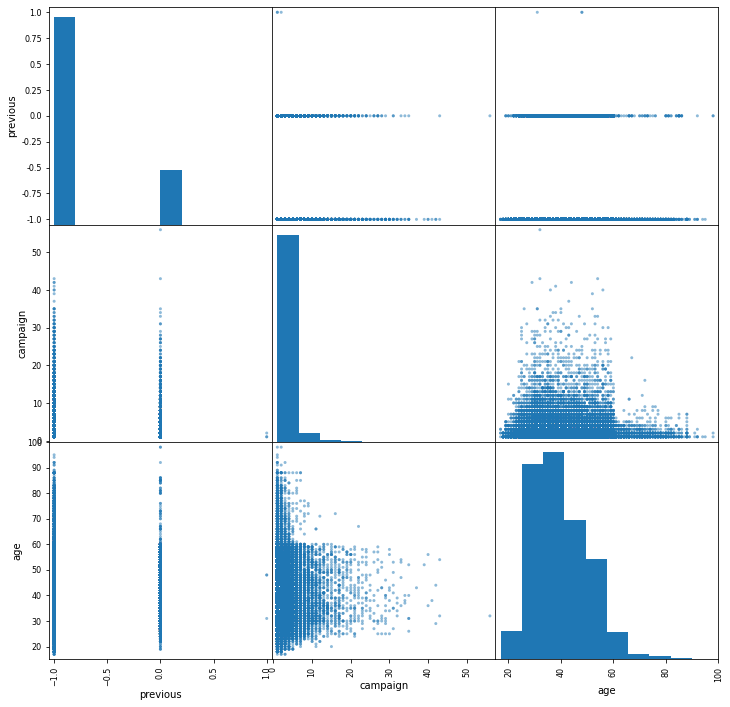

In [74]:
scatter_matrix(train_data[["previous", "campaign", "age"]], figsize=(12, 12))
plt.show()

No destructive data is found, however, the model that is trained on this data will predict if users **DO NOT** subscribe to the bank plan, rather than the other way around.

# Cleaning

Taking the notes written above into account, `pdays` and `duration` columns will be removed to preserve the model prediction correctness.

In [75]:
def dropColumns(dataset):
  dataset.drop('pdays', axis=1, inplace=True)
  dataset.drop('duration', axis=1, inplace=True)
  dataset.drop('subscribed', axis=1, inplace=True)

dropColumns(train_data)
dropColumns(test_data)

In [76]:
train_data

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  campaign  previous     poutcome  \
0      telephone   may         mon         1        -1  nonexistent   
1      telephone   may         mon         1         0  nonexistent   
2      telephone   may         mon         1        -1  nonexistent   
3      telephone   may         mon         1        -1  nonexistent   
4      telephone   may         mon         1        -1  nonexistent   
...          ...   ...         ...       ...       ...          ...   
41183   cellular   nov         fri         1        -1  nonexistent   
41184   cellular   nov         fri         1        -1  nonexistent   
41185   cellular   nov         fri         2        -1  nonexistent   
41186   cellular   nov         fri         1        -1  nonexistent   
41187   cellular   nov         fri         3        -1      failure   

       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  \
0               1.1          93.994          -36.4      4.857       5191.0   
1               1.1          93.994          -36.4      4.857       5191.0   
2               1.1          93.994          -36.4      4.857       5191.0   
3               1.1          93.994          -36.4      4.857       5191.0   
4               1.1          93.994          -36.4      4.857       5191.0   
...             ...             ...            ...        ...          ...   
41183          -1.1          94.767          -50.8      1.028       4963.6   
41184          -1.1          94.767          -50.8      1.028       4963.6   
41185          -1.1          94.767          -50.8      1.028       4963.6   
41186          -1.1          94.767          -50.8      1.028       4963.6   
41187          -1.1          94.767          -50.8      1.028       4963.6   

         y  
0       no  
1       no  
2       no  
3       no  
4       no  
...    ...  
41183  yes  
41184   no  
41185   no  
41186  yes  
41187   no  

[41188 rows x 19 columns]

Fortunately, there are no missing columns, however, there are states that describe missing data such as: **unknown**, **0**, **999**, **nonexistent**. I wish to keep this as is since it refers to `employment`, `call statistics` and `previous campaing statistics`. This type of **missing data** provides meaningful semantic value to the dataset.

In [77]:
train_data.isnull().values.any()

False

In [78]:
train_data.isin(['unknown', '0', '999', 'nonexistent']).sum()

age                   0
job                 330
marital              80
education          1731
default            8597
housing             990
loan                990
contact               0
month                 0
day_of_week           0
campaign              0
previous              0
poutcome          35563
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
dtype: int64

# Balancing

Now that the data is cleaned, it is time to balance it.

In [79]:
train_data['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

After cleaning the data set looks like this:

In [80]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  previous        41188 non-null  int64  
 12  poutcome        41188 non-null  object 
 13  emp.var.rate    41188 non-null  float64
 14  cons.price.idx  41188 non-null  float64
 15  cons.conf.idx   41188 non-null  float64
 16  euribor3m       41188 non-null  float64
 17  nr.employed     41188 non-null 

In [173]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import seaborn as sns

## Labelling and Encoding

The first step is to assign numerical codes to the attributes which are not numers already. I choose to label everything in a **one-hot numeric way** such that models do not make relations between values (*ie: no > yes, unknown+no = yes, divorced < single, unknown > married*).

As a future test, i can try using a **Label encoder for `job`, `poutcome`, `loan` and `housing`** to inspect differences in the model training.

In [233]:
def hotEncode(data_set, column_name):
  encoder = OneHotEncoder(sparse=False)
  encoded_x = pd.DataFrame(encoder.fit_transform(data_set[[column_name]]))
  encoded_x.columns = encoder.get_feature_names_out([column_name])
  new_set = data_set.drop([column_name], axis=1, inplace=False)
  return pd.concat([new_set, encoded_x ], axis=1)

def hotEncodeMany(data_set, columns):
  if (not columns or columns == None or len(columns) == 0):
    return data_set
  else:
    return hotEncodeMany(hotEncode(data_set, columns[0]), columns[1:])

def hotEncodeDataSet(data_set):
  encoded_data_set = hotEncodeMany(data_set, ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])

  y_le = LabelEncoder()
  encoded_data_set['y'] = y_le.fit_transform(encoded_data_set['y'])

  return encoded_data_set

encoded_train_data = hotEncodeDataSet(train_data)
encoded_test_data = hotEncodeDataSet(test_data)

encoded_train_data.info()

# The method below is abandoned due to not being able to keep column_names
# ct = ColumnTransformer(
#     [
#      ("job", OneHotEncoder(),[1]),
#      ("marital", OneHotEncoder(),[2]),
#      ("education", OneHotEncoder(),[3]),
#      ("default", OneHotEncoder(),[4]),
#      ("housing", OneHotEncoder(),[5]),
#      ("loan", OneHotEncoder(),[6]),
#      ("contact", OneHotEncoder(),[7]),
#      ("month", OneHotEncoder(),[8]),
#      ("day_of_week", OneHotEncoder(),[9]),
#      ("poutcome", OneHotEncoder(),[12])
#     ],
#     remainder="passthrough"
# )
# encoded_train_data = pd.DataFrame(ct.fit_transform(train_data))
# encoded_train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   previous                       41188 non-null  int64  
 3   emp.var.rate                   41188 non-null  float64
 4   cons.price.idx                 41188 non-null  float64
 5   cons.conf.idx                  41188 non-null  float64
 6   euribor3m                      41188 non-null  float64
 7   nr.employed                    41188 non-null  float64
 8   y                              41188 non-null  int64  
 9   job_admin.                     41188 non-null  float64
 10  job_blue-collar                41188 non-null  float64
 11  job_entrepreneur               41188 non-null  float64
 12  job_housemaid                  41188 non-null 

## Analize balance

Now it is time to see how bad the situation is by preparing a 2D array of thescattered `y` output.

In [160]:
pca = PCA(n_components='mle', svd_solver='full')
data_2d = pd.DataFrame(pca.fit_transform(encoded_train_data.iloc[:,0:61]))

data_2d= pd.concat([data_2d, encoded_train_data['y']], axis=1)
# data_2d.columns = ['x', 'y', 'yes']

data_2d

0          1          2         3         4         5  \
0      -23.979764  16.291155   2.906707 -1.627112  1.065630 -0.079231   
1      -23.980241  17.293181   2.823890 -1.628676  1.322669  1.029336   
2      -24.028357  -2.665948   4.264779 -1.559576  0.981290 -0.059319   
3      -24.021138   0.327465   4.064291 -1.565831  1.041911 -0.068138   
4      -23.979676  16.275995   2.899503 -1.625875  1.057168 -0.198990   
...           ...        ...        ...       ...       ...       ...   
41183  203.572526  31.749811 -10.983536 -0.714774  3.664637 -2.118588   
41184  203.499499   4.822065  -9.047238 -0.614910  3.923396 -1.226411   
41185  203.521585  14.799405  -9.784596  0.349438  3.607595 -2.011503   
41186  203.495954   2.827820  -8.882263 -0.606913  3.833294 -1.572523   
41187  203.566327  32.749328 -11.129469  1.275743  3.538605 -2.052732   

              6         7         8         9        10        11        12  \
0     -0.774977 -0.700645 -0.137029 -0.103022 -0.132096 -0.012580 -0.101388   
1     -0.490291  0.147711  0.506189 -0.034023  0.030124  1.119605  0.369953   
2      0.622240 -0.964057 -0.245925 -0.178292 -0.055110  1.075637  0.213769   
3     -0.760168 -0.618707 -0.160746  0.482241 -0.126563  0.342308 -0.202858   
4     -0.713544 -0.818122  0.026244 -0.177643  1.425143  0.769130  0.212524   
...         ...       ...       ...       ...       ...       ...       ...   
41183  0.849554  1.097658 -1.003487 -0.219546 -0.291850 -0.136826  0.412291   
41184 -0.404526  1.326297 -1.596746 -0.212283 -0.206100 -0.367242  0.076243   
41185  0.865421  1.188226 -0.995619  0.678442 -0.389753 -0.211301 -0.006651   
41186 -0.427981  1.481257 -1.542757 -0.137722 -0.265766 -0.326979  1.033393   
41187  0.836238  1.050405 -0.993755 -0.256143 -0.270573 -0.084455  0.376155   

             13        14        15        16        17        18        19  \
0     -0.135756 -0.575915 -0.831453 -0.060538 -0.007312  0.000294  0.150748   
1     -0.235982 -0.496904 -0.801519  0.050687 -0.052837  0.092690  0.441805   
2     -0.119242 -0.517543 -0.808300 -0.021201 -0.016601  0.105859  0.482076   
3     -0.163875 -0.558416 -0.835913 -0.073436  0.033472 -0.035835 -0.396067   
4     -0.167396 -0.474700 -0.851869 -0.000553 -0.055954  0.071407  0.430418   
...         ...       ...       ...       ...       ...       ...       ...   
41183 -0.294150 -0.009944  0.492094  0.140206  0.909292 -0.346988  0.058639   
41184 -0.168665 -0.080326  0.402589  0.067675  0.973121 -0.241909 -0.072372   
41185 -0.279473 -0.054408  0.407296  0.076242  0.910390 -0.147262  0.586378   
41186 -0.558373 -0.084917  0.523481  0.171077  0.870696 -0.304575  0.000062   
41187 -0.448650 -0.041531  0.537476  0.157179  0.986730  1.006483 -0.301462   

             20        21        22        23        24        25        26  \
0     -0.339192 -0.112169 -0.575396  0.053707 -0.416298  0.359000  0.563423   
1     -0.292591 -0.020848  0.334952 -0.005318 -0.052453  0.083946 -0.172999   
2     -0.226412  0.151205  0.133216 -0.049236 -0.155822  0.167712 -0.105923   
3      0.142238 -0.406953 -0.272106  0.047962 -0.087560  0.127729 -0.490955   
4     -0.387827  0.042616  0.271444 -0.021831 -0.074534  0.094671 -0.173426   
...         ...       ...       ...       ...       ...       ...       ...   
41183 -0.073187 -0.346340  0.236959  1.454690  0.073356  0.581180 -0.442168   
41184  0.138623 -0.072659 -0.106554  1.682695 -0.261762 -0.404657 -0.631006   
41185 -0.182782  0.154887  0.304304  1.416235 -0.261692 -0.399141 -0.027161   
41186  0.273998 -0.284799  0.140171  1.486632  0.338408  0.338250 -0.054414   
41187 -0.298156 -0.309098  0.158488  1.162960 -0.517483 -0.119203 -0.459109   

             27        28        29        30        31        32        33  \
0      0.046147 -0.065306  0.065565  0.258295  0.029001 -0.168384 -0.103732   
1     -0.108756  0.030270 -0.360822 -0.283456  0.132661  0.025561 -0.029282   
2     -0.093286  0.031178 -0.321676 -0.183422  0.120649

In [157]:
data_2d['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

The plot determines an overall *ambiguous* output distribution

In [181]:
import plotly.express as px
# sns.lmplot(x="x", y="y", data=data_2d, fit_reg=False, hue='yes')

components = pca.fit_transform(data_2d)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=data_2d["y"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Now it is time to overpopulate using `ADASYN`

In [177]:
from imblearn.over_sampling import ADASYN

ada = ADASYN()
X_resampled, y_resampled = ada.fit_resample(encoded_train_data.iloc[:,0:61], encoded_train_data['y'])
data_oversampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
data_oversampled.columns = encoded_train_data.columns

## Inspect Differences

Now we can inspect the difference in the PCA plot

In [179]:
data_oversampled['y'].value_counts()

0    36548
1    36376
Name: y, dtype: int64

In [190]:
diff_pca = PCA(n_components='mle', svd_solver='full')
diff_data_2d = pd.DataFrame(diff_pca.fit_transform(data_oversampled.iloc[:,0:61]))
diff_data_2d = pd.concat([diff_data_2d, data_oversampled['y']], axis=1)

diff_components = diff_pca.fit_transform(diff_data_2d)
diff_labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(diff_pca.explained_variance_ratio_ * 100)
}
diff_fig = px.scatter_matrix(
    diff_components,
    labels=diff_labels,
    dimensions=range(4),
    color=diff_data_2d["y"]
)
diff_fig.update_traces(diagonal_visible=False)
diff_fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



# Model Training

`train_data` got through a series of processed. It was analyzed, cleaned, labelled and balanced. The data set `data_oversampled` should now be ready for models to be trained on

## Decision Tree

Let's build the classifier (model) in form of a decision tree.

In [221]:
from sklearn import tree

classifier = tree.DecisionTreeClassifier(criterion = "entropy")

In [222]:
x_train = data_oversampled.drop('y', axis=1)
y_train = data_oversampled['y']

Given `x_train` the data we want to process, and `y_train` the output to be predicted, we can now create the model.

In [223]:
classifier.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [224]:
import graphviz
from sklearn.tree import export_text

dot_data = tree.export_graphviz(classifier, out_file = None, feature_names = x_train.columns)

graph = graphviz.Source(dot_data)
graphviz.Source(dot_data).view()
graph.render("decisions")

print(export_text(classifier, feature_names = list(x_train.columns)))

|--- poutcome_success <= 0.50
|   |--- class: 0
|--- poutcome_success >  0.50
|   |--- class: 1



A huge problem is spotted straight away.

It turns out that sklearn's decision tree cannot handle categorical data. There is a Github issue on this [#4899](https://github.com/scikit-learn/scikit-learn/pull/4899) from June 2015 (once closed it continued in [#12866](https://github.com/scikit-learn/scikit-learn/pull/12866), so the issue is still not resolved).

However, i think hot encoding solves this problem [see this documentation for information](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features). I'm doing something wrong, but i'm not sure what.

Currently, i think the **oversamples** are faulty. They might need to be recleaned, or it might be helpful to select a percentage of them.

The last glimpse of hope stands in removing columns that might create abnormal relations and comparing the result with the decision tree of the origianl encoded data set.

In [230]:
def exportDecisionTreeFrom(data_set, export_name):
  x_axis = data_set.drop('y', axis=1)
  y_axis = data_set['y']

  c = tree.DecisionTreeClassifier(criterion = "entropy")
  c.fit(x_axis, y_axis)

  dd = tree.export_graphviz(c, out_file = None, feature_names = x_axis.columns)

  graph = graphviz.Source(dd)
  graphviz.Source(dd).view()
  graph.render(export_name)

  return c


In [ ]:
exportDecisionTreeFrom(encoded_train_data, 'o_decisions')

In [231]:
fixed_classifier = exportDecisionTreeFrom(
    data_oversampled.drop(['poutcome_success'], axis=1),
    'n_decisions'
)

After removing the faulty **poutcome_success** column, the number of conditions in the decision tree seems to be larger.

### Testing the model

In order to test the model with data from the **test data set**, we need to perform the same labelling and encoding process, and then use the `fixed_classifier` to predict the output.

Fortunately, **every processing step** was performed both for the `train_data` and the `test_data`

In [239]:
test_data.isnull().values.any()

False

In [240]:
encoded_test_data.isnull().values.any()

False

In [243]:
encoded_test_data['y'].value_counts()

0    3668
1     451
Name: y, dtype: int64

In [236]:
encoded_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   campaign                       4119 non-null   int64  
 2   previous                       4119 non-null   int64  
 3   emp.var.rate                   4119 non-null   float64
 4   cons.price.idx                 4119 non-null   float64
 5   cons.conf.idx                  4119 non-null   float64
 6   euribor3m                      4119 non-null   float64
 7   nr.employed                    4119 non-null   float64
 8   y                              4119 non-null   int64  
 9   job_admin.                     4119 non-null   float64
 10  job_blue-collar                4119 non-null   float64
 11  job_entrepreneur               4119 non-null   float64
 12  job_housemaid                  4119 non-null   f

In [246]:
x_test = encoded_test_data.drop(['y', 'poutcome_success'], axis=1)
y_test = encoded_test_data['y']
y_test_pred = fixed_classifier.predict(x_test)

y_test, y_test_pred

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 4114    0
 4115    0
 4116    0
 4117    0
 4118    0
 Name: y, Length: 4119, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))

In [255]:
prediction_success = np.array(y_test == y_test_pred)
p_total = len(prediction_success)
p_success_count = np.count_nonzero(prediction_success)
p_failed_count = p_total - p_success_count

print("From a total of {total} samples, {success} were successfully predicted, {fail} were wrong: {srate}% success rate".format(
    total=p_total,
    success=p_success_count,
    fail=p_failed_count,
    srate=p_success_count / p_total * 100
))

From a total of 4119 samples, 4092 were successfully predicted, 27 were wrong: 99.34450109249818% success rate


In [259]:
print("Accuracy: ", fixed_classifier.score(x_test, y_test))

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

Accuracy:  0.9934450109249818
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3668
           1       1.00      0.94      0.97       451

    accuracy                           0.99      4119
   macro avg       1.00      0.97      0.98      4119
weighted avg       0.99      0.99      0.99      4119

[[3667    1]
 [  26  425]]


# 👍

From a total of 4119 samples, 4092 were successfully predicted, 27 were wrong: 99.34450109249818% success rate